In [ ]:
##Himachal_X_LST

Total pixels inside Himachal Pradesh: 65575
2020 June → LST missing: 1208/65575 (1.84%)
2020 June → Precip missing: 1208/65575 (1.84%)
2020 July → LST missing: 1208/65575 (1.84%)
2020 July → Precip missing: 1208/65575 (1.84%)
2020 August → LST missing: 1555/65575 (2.37%)
2020 August → Precip missing: 1208/65575 (1.84%)
2020 September → LST missing: 1208/65575 (1.84%)
2020 September → Precip missing: 1208/65575 (1.84%)
2021 June → LST missing: 1208/65575 (1.84%)
2021 June → Precip missing: 1208/65575 (1.84%)
2021 July → LST missing: 1211/65575 (1.85%)
2021 July → Precip missing: 1208/65575 (1.84%)
2021 August → LST missing: 1209/65575 (1.84%)
2021 August → Precip missing: 1208/65575 (1.84%)
2021 September → LST missing: 1208/65575 (1.84%)
2021 September → Precip missing: 1208/65575 (1.84%)
2022 June → LST missing: 1208/65575 (1.84%)
2022 June → Precip missing: 1208/65575 (1.84%)
2022 July → LST missing: 2101/65575 (3.20%)
2022 July → Precip missing: 1208/65575 (1.84%)
2022 August → LST 

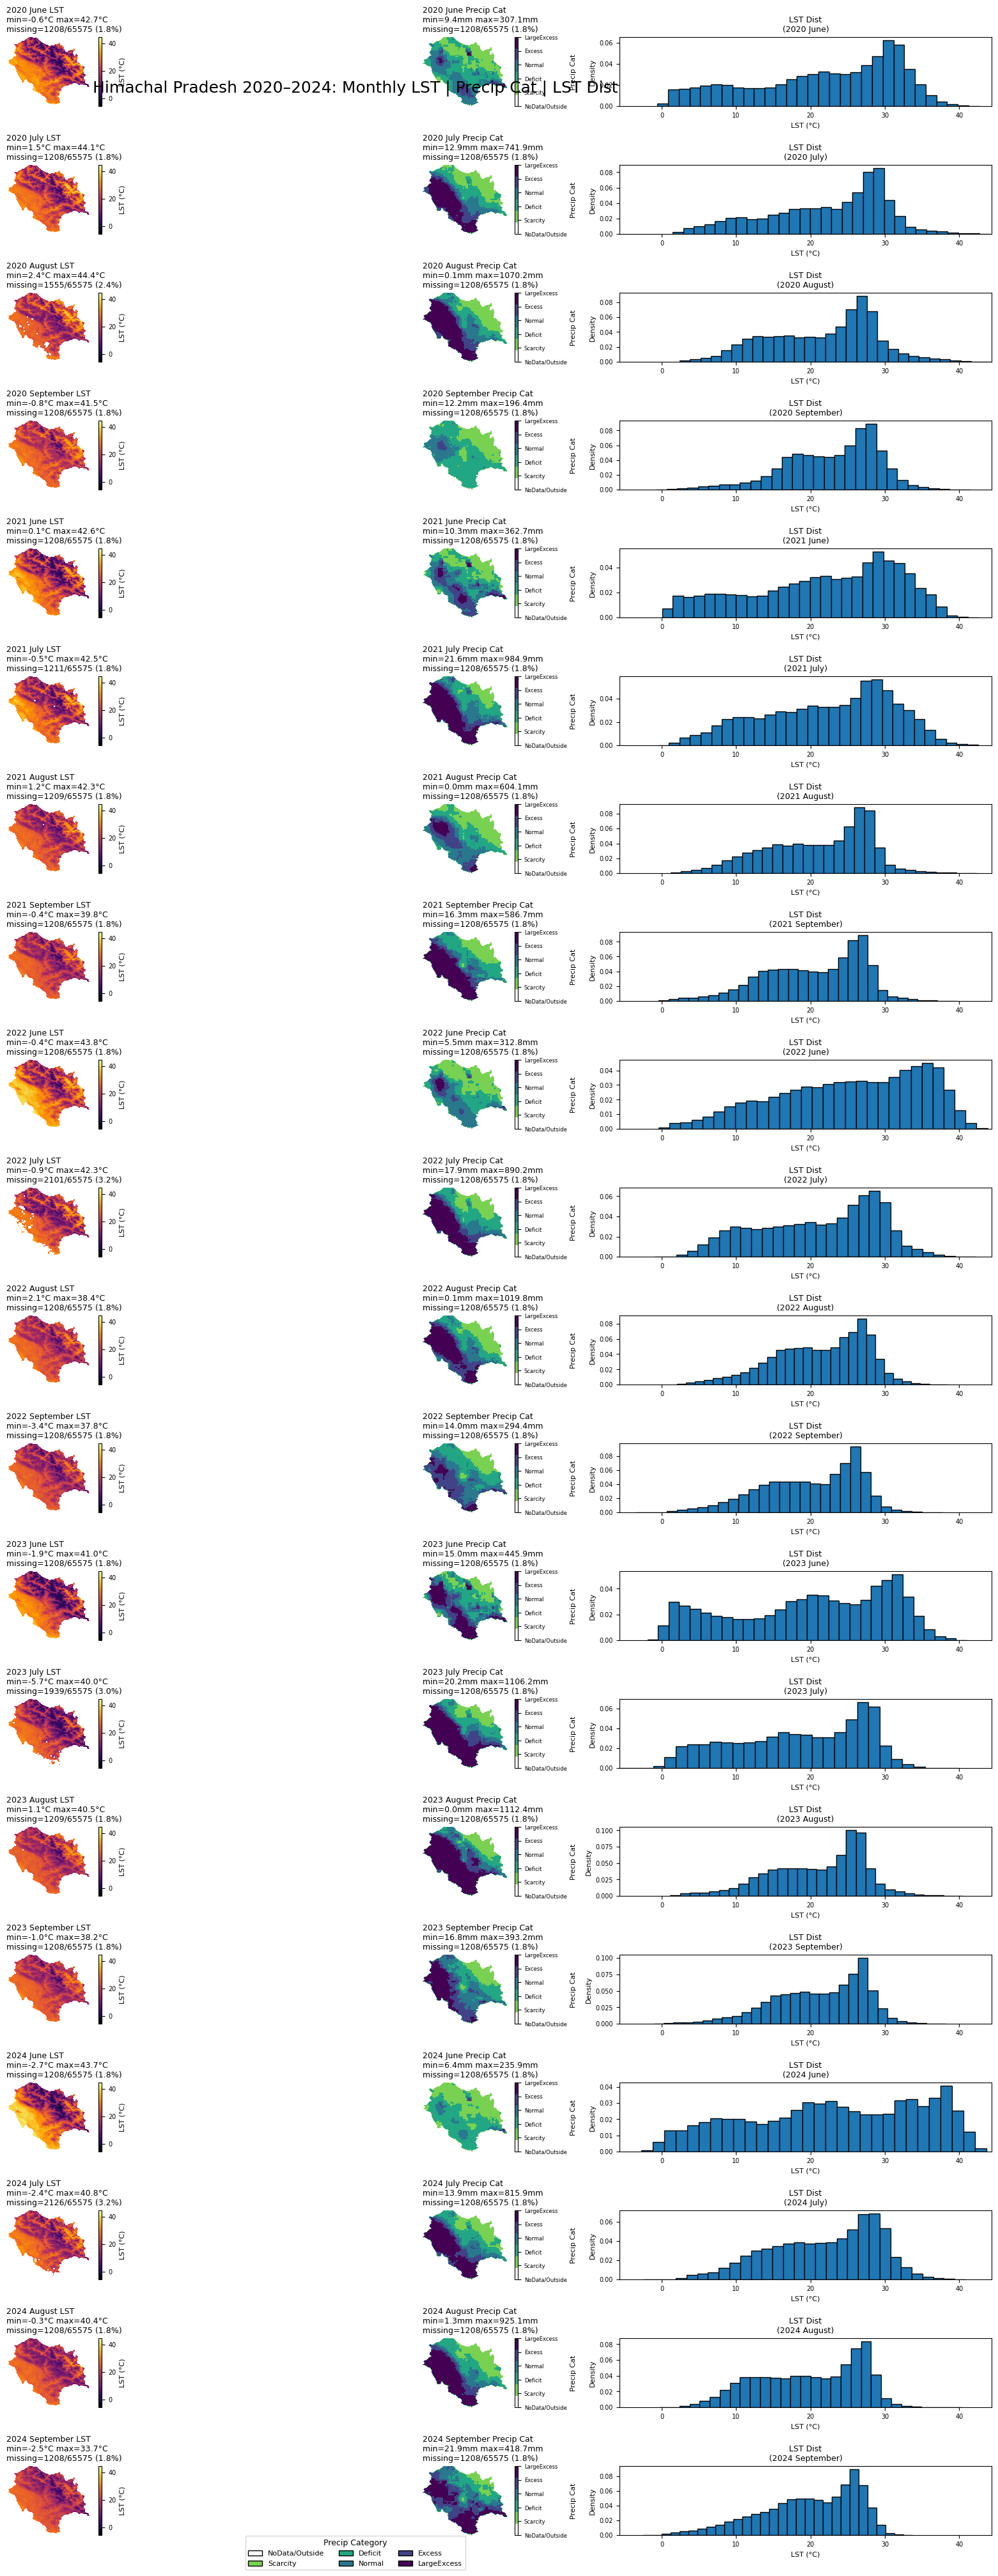

In [3]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Himachal Pradesh)
# -----------------------------------------------------------------------------
lst_tiff_path        = "Himachal_X_LST.tif"                      # 20 bands (2020–2024 × 4: Jun–Sep)
precip_raw_tiff_path = "Himachal_Y_Precipitation_CHIRPS.tif"     # 25 bands (2020–2024 × 5)
precip_cat_tiff_path = "Himachal_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shapefile      = "SateMask/gadm41_IND_1.shp"                     # contains all Indian states

for p in (lst_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) LOAD INDIA STATES & BUILD HP MASK
# -----------------------------------------------------------------------------
gdf = gpd.read_file(india_shapefile)
gdf_hp = gdf[gdf["NAME_1"].str.lower() == "himachal pradesh"]
if gdf_hp.empty:
    raise ValueError("No 'Himachal Pradesh' feature found in shapefile.")

with rasterio.open(lst_tiff_path) as src:
    transform = src.transform
    crs       = src.crs
    height    = src.height
    width     = src.width

if gdf_hp.crs != crs:
    gdf_hp = gdf_hp.to_crs(crs)

hp_geom = [gdf_hp.geometry.union_all()]
hp_mask = geometry_mask(
    hp_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)

total_inside = np.count_nonzero(hp_mask)
print(f"Total pixels inside Himachal Pradesh: {total_inside}")

# -----------------------------------------------------------------------------
# 3) READ & MASK LST
# -----------------------------------------------------------------------------
with rasterio.open(lst_tiff_path) as src:
    lst_bands = src.read().astype(np.float32)  # (20, H, W)

if lst_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {lst_tiff_path}, found {lst_bands.shape[0]}")

for i in range(lst_bands.shape[0]):
    b = lst_bands[i]
    b[~hp_mask] = np.nan
    lst_bands[i] = b

# -----------------------------------------------------------------------------
# 4) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in raw precip, found {pr_raw_full.shape[0]}")

for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~hp_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 5) READ & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in precip cat, found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~hp_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 6) EXTRACT 20 MONTHLY BANDS (drop each year's “Total”)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]

precip_raw_bands = pr_raw_full[monthly_idxs]  # (20,H,W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20,H,W)

# -----------------------------------------------------------------------------
# 7) SETUP YEARS, MONTHS & COLORMAPS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
months      = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(months)
n_total     = n_years * n_months  # 20

all_lst = lst_bands.flatten()
all_lst = all_lst[~np.isnan(all_lst)]
lst_vmin = float(np.nanmin(all_lst)) if all_lst.size else 0.0
lst_vmax = float(np.nanmax(all_lst)) if all_lst.size else 50.0
lst_cmap = plt.get_cmap("inferno")

cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0:"NoData/Outside",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cluster_handles = [Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
                   for i in range(6)]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Himachal Pradesh 2020–2024: Monthly LST | Precip Cat | LST Dist", fontsize=18, y=0.97)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP & PLOT WITH MISSING STATS
# -----------------------------------------------------------------------------
for i in range(n_total):
    yidx, midx = divmod(i, n_months)
    year, mon = years[yidx], months[midx]

    # LST
    layer = lst_bands[i]
    valid = layer[~np.isnan(layer)]
    mn, mx = (float(np.nanmin(valid)), float(np.nanmax(valid))) if valid.size else (np.nan, np.nan)
    miss = np.count_nonzero(np.isnan(layer[hp_mask]))
    pct  = miss/total_inside*100
    print(f"{year} {mon} → LST missing: {miss}/{total_inside} ({pct:.2f}%)")

    # Precip
    pr_layer = precip_raw_bands[i]
    vpr = pr_layer[~np.isnan(pr_layer)]
    pr_min, pr_max = (float(np.nanmin(vpr)), float(np.nanmax(vpr))) if vpr.size else (np.nan, np.nan)
    miss_pr = np.count_nonzero(np.isnan(pr_layer[hp_mask]))
    pct_pr  = miss_pr/total_inside*100
    print(f"{year} {mon} → Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # Category
    rc = precip_cat_bands[i]
    cp = np.zeros_like(rc, dtype=np.int8)
    ok = (rc != -1)
    cp[ok] = rc[ok] + 1

    # Column 0
    ax0 = axes[i,0]
    im0 = ax0.imshow(layer, cmap=lst_cmap, vmin=lst_vmin, vmax=lst_vmax)
    t0 = (f"{year} {mon} LST\nmin={mn:.1f}°C max={mx:.1f}°C\n"
          f"missing={miss}/{total_inside} ({pct:.1f}%)")
    ax0.set_title(t0, loc="left", fontsize=9); ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_label("LST (°C)", fontsize=8); c0.ax.tick_params(labelsize=7)

    # Column 1
    ax1 = axes[i,1]
    im1 = ax1.imshow(cp, cmap=cluster_cmap, vmin=0, vmax=5)
    t1 = (f"{year} {mon} Precip Cat\nmin={pr_min:.1f}mm max={pr_max:.1f}mm\n"
          f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)")
    ax1.set_title(t1, loc="left", fontsize=9); ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5]); c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6); c1.set_label("Precip Cat", fontsize=8)

    # Column 2
    ax2 = axes[i,2]
    if valid.size:
        ax2.hist(valid.flatten(), bins=30, density=True, edgecolor="black")
        ax2.set_xlim(lst_vmin, lst_vmax)
    else:
        ax2.text(0.5,0.5,"No Data",ha="center",va="center",fontsize=8,color="gray")
    ax2.set_title(f"LST Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("LST (°C)", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) LEGEND
# -----------------------------------------------------------------------------
fig.legend(handles=cluster_handles,
           labels=[cluster_labels[j] for j in range(6)],
           loc="lower center", ncol=3, frameon=True,
           title="Precip Category", fontsize=8, title_fontsize=9,
           bbox_to_anchor=(0.5,-0.005))

plt.show()


In [ ]:
##Himachal_X_NDVI

In [11]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Himachal Pradesh)
# -----------------------------------------------------------------------------
ndvi_tiff_path       = "Himachal_X_NDVI.tif"
precip_raw_tiff_path = "Himachal_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path = "Himachal_Y_Precipitation_GT_geotif.tif"
india_shapefile      = "SateMask/gadm41_IND_1.shp"

for p in (ndvi_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20-BAND NDVI TIFF (2020–2024 × Jun–Sep)
# -----------------------------------------------------------------------------
with rasterio.open(ndvi_tiff_path) as src:
    ndvi_bands     = src.read().astype(np.float32)  # (20, H, W)
    transform      = src.transform
    crs            = src.crs
    height, width  = src.height, src.width
    bounds         = src.bounds

if ndvi_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {ndvi_tiff_path}, found {ndvi_bands.shape[0]}")

# -----------------------------------------------------------------------------
# 3) LOAD & FILTER HIMACHAL PRADESH → BUILD MASK
# -----------------------------------------------------------------------------
gdf = gpd.read_file(india_shapefile)
gdf_hp = gdf[gdf["NAME_1"].str.lower() == "himachal pradesh"].copy()
if gdf_hp.empty:
    raise ValueError("No 'Himachal Pradesh' feature found in shapefile.")
if gdf_hp.crs != crs:
    gdf_hp = gdf_hp.to_crs(crs)

hp_geom = [gdf_hp.geometry.union_all()]
hp_mask = geometry_mask(
    hp_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)
total_inside = np.count_nonzero(hp_mask)
print(f"Total pixels inside Himachal Pradesh: {total_inside}")

# mask NDVI outside HP → NaN
for i in range(ndvi_bands.shape[0]):
    band = ndvi_bands[i]
    band[~hp_mask] = np.nan
    ndvi_bands[i] = band

# -----------------------------------------------------------------------------
# 4) READ & MASK RAW PRECIPITATION (25 bands)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)
if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff_path}, found {pr_raw_full.shape[0]}")
for i in range(25):
    arr = pr_raw_full[i]
    arr[~hp_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 5) READ & MASK PRECIPITATION CATEGORY (25 bands)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)
if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff_path}, found {pr_cat_full.shape[0]}")
for i in range(25):
    arr = pr_cat_full[i]
    arr[~hp_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 6) EXTRACT 20 MONTHLY PRECIP BANDS (drop every 5th = totals)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs.extend([base + m for m in range(4)])
precip_raw_bands = pr_raw_full[monthly_idxs]  # (20, H, W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20, H, W)

# -----------------------------------------------------------------------------
# 7) YEARS & MONTHS arrays
# -----------------------------------------------------------------------------
years  = [2020, 2021, 2022, 2023, 2024]
months = ["June", "July", "August", "September"]
n_months = len(months)
n_total  = len(years) * n_months  # 20

# -----------------------------------------------------------------------------
# 8) COLORMAPS & LEGENDS
# -----------------------------------------------------------------------------
ndvi_cmap = plt.get_cmap("viridis")
ndvi_vmin, ndvi_vmax = -1.0, 1.0

cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
                   for i in range(6)]

# -----------------------------------------------------------------------------
# 9) BUILD FIGURE & PLOT WITH MISSING‐DATA PRINTS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(22, n_total*2.2), constrained_layout=True)
fig.suptitle("Himachal Pradesh 2020–2024: Monthly NDVI | Precip Cat | NDVI Dist", fontsize=18, y=0.98)
if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    y_idx, m_idx = divmod(i, n_months)
    year, mon = years[y_idx], months[m_idx]

    # --- NDVI statistics & missing count/%
    ndvi_layer = ndvi_bands[i]
    valid_ndvi = ndvi_layer[~np.isnan(ndvi_layer)]
    ndvi_min = float(np.nanmin(valid_ndvi)) if valid_ndvi.size else np.nan
    ndvi_max = float(np.nanmax(valid_ndvi)) if valid_ndvi.size else np.nan
    missing_ndvi = np.count_nonzero(np.isnan(ndvi_layer[hp_mask]))
    pct_ndvi     = missing_ndvi / total_inside * 100
    print(f"{year} {mon} → Missing NDVI: {missing_ndvi}/{total_inside} ({pct_ndvi:.2f}%)")

    # --- Raw precip stats & missing
    pr_layer = precip_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan
    missing_pr = np.count_nonzero(np.isnan(pr_layer[hp_mask]))
    pct_pr     = missing_pr / total_inside * 100
    print(f"{year} {mon} → Raw Precip missing: {missing_pr}/{total_inside} ({pct_pr:.2f}%)")

    # --- Precip category → shift -1..4 to 0..5
    rc = precip_cat_bands[i]
    cat_plot = np.zeros_like(rc, dtype=np.int8)
    mask_ok = (rc != -1)
    cat_plot[mask_ok] = rc[mask_ok] + 1

    # — Column 0: NDVI Map —
    ax0 = axes[i, 0]
    im0 = ax0.imshow(ndvi_layer, cmap=ndvi_cmap, vmin=ndvi_vmin, vmax=ndvi_vmax,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], origin="upper")
    ax0.set_title(
        f"{year} {mon} NDVI\nmin={ndvi_min:.2f}, max={ndvi_max:.2f}\n"
        f"missing={missing_ndvi}/{total_inside} ({pct_ndvi:.1f}%)",
        loc="left", fontsize=9
    )
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.045, pad=0.02)
    c0.set_label("NDVI", fontsize=8); c0.ax.tick_params(labelsize=7)

    # — Column 1: Precip Cat Map —
    ax1 = axes[i, 1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], origin="upper")
    ax1.set_title(
        f"{year} {mon} Precip Cat\nmin={pr_min:.1f} mm, max={pr_max:.1f} mm\n"
        f"missing={missing_pr}/{total_inside} ({pct_pr:.1f}%)",
        loc="left", fontsize=9
    )
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=7); c1.set_label("Precip Category", fontsize=8)

    # — Column 2: NDVI Distribution —
    ax2 = axes[i, 2]
    if valid_ndvi.size:
        ax2.hist(valid_ndvi.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(ndvi_vmin, ndvi_vmax)
    else:
        ax2.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"NDVI Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("NDVI", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) BOTTOM LEGEND FOR PRECIP CATEGORIES
# -----------------------------------------------------------------------------
fig.legend(handles=cluster_handles, loc="lower center", ncol=3,
           frameon=True, title="Precip Category Definitions",
           bbox_to_anchor=(0.5, -0.005), fontsize=8, title_fontsize=9)

plt.show()


Total pixels inside Himachal Pradesh: 65575
2020 June → Missing NDVI: 1208/65575 (1.84%)
2020 June → Raw Precip missing: 1208/65575 (1.84%)
2020 July → Missing NDVI: 1208/65575 (1.84%)
2020 July → Raw Precip missing: 1208/65575 (1.84%)
2020 August → Missing NDVI: 1210/65575 (1.85%)
2020 August → Raw Precip missing: 1208/65575 (1.84%)
2020 September → Missing NDVI: 1211/65575 (1.85%)
2020 September → Raw Precip missing: 1208/65575 (1.84%)
2021 June → Missing NDVI: 1208/65575 (1.84%)
2021 June → Raw Precip missing: 1208/65575 (1.84%)
2021 July → Missing NDVI: 1224/65575 (1.87%)
2021 July → Raw Precip missing: 1208/65575 (1.84%)
2021 August → Missing NDVI: 1208/65575 (1.84%)
2021 August → Raw Precip missing: 1208/65575 (1.84%)
2021 September → Missing NDVI: 1230/65575 (1.88%)
2021 September → Raw Precip missing: 1208/65575 (1.84%)
2022 June → Missing NDVI: 1208/65575 (1.84%)
2022 June → Raw Precip missing: 1208/65575 (1.84%)
2022 July → Missing NDVI: 1208/65575 (1.84%)
2022 July → Raw Pre

In [ ]:
##Himachal_X_Relative_Humidity


Total pixels inside Himachal Pradesh: 65575
2020 June → Missing RH: 1208/65575 (1.84%)
2020 June → Raw Precip missing: 1208/65575 (1.84%)
2020 July → Missing RH: 1208/65575 (1.84%)
2020 July → Raw Precip missing: 1208/65575 (1.84%)
2020 August → Missing RH: 1208/65575 (1.84%)
2020 August → Raw Precip missing: 1208/65575 (1.84%)
2020 September → Missing RH: 1208/65575 (1.84%)
2020 September → Raw Precip missing: 1208/65575 (1.84%)
2021 June → Missing RH: 1208/65575 (1.84%)
2021 June → Raw Precip missing: 1208/65575 (1.84%)
2021 July → Missing RH: 1208/65575 (1.84%)
2021 July → Raw Precip missing: 1208/65575 (1.84%)
2021 August → Missing RH: 1208/65575 (1.84%)
2021 August → Raw Precip missing: 1208/65575 (1.84%)
2021 September → Missing RH: 1208/65575 (1.84%)
2021 September → Raw Precip missing: 1208/65575 (1.84%)
2022 June → Missing RH: 1208/65575 (1.84%)
2022 June → Raw Precip missing: 1208/65575 (1.84%)
2022 July → Missing RH: 1208/65575 (1.84%)
2022 July → Raw Precip missing: 1208/65

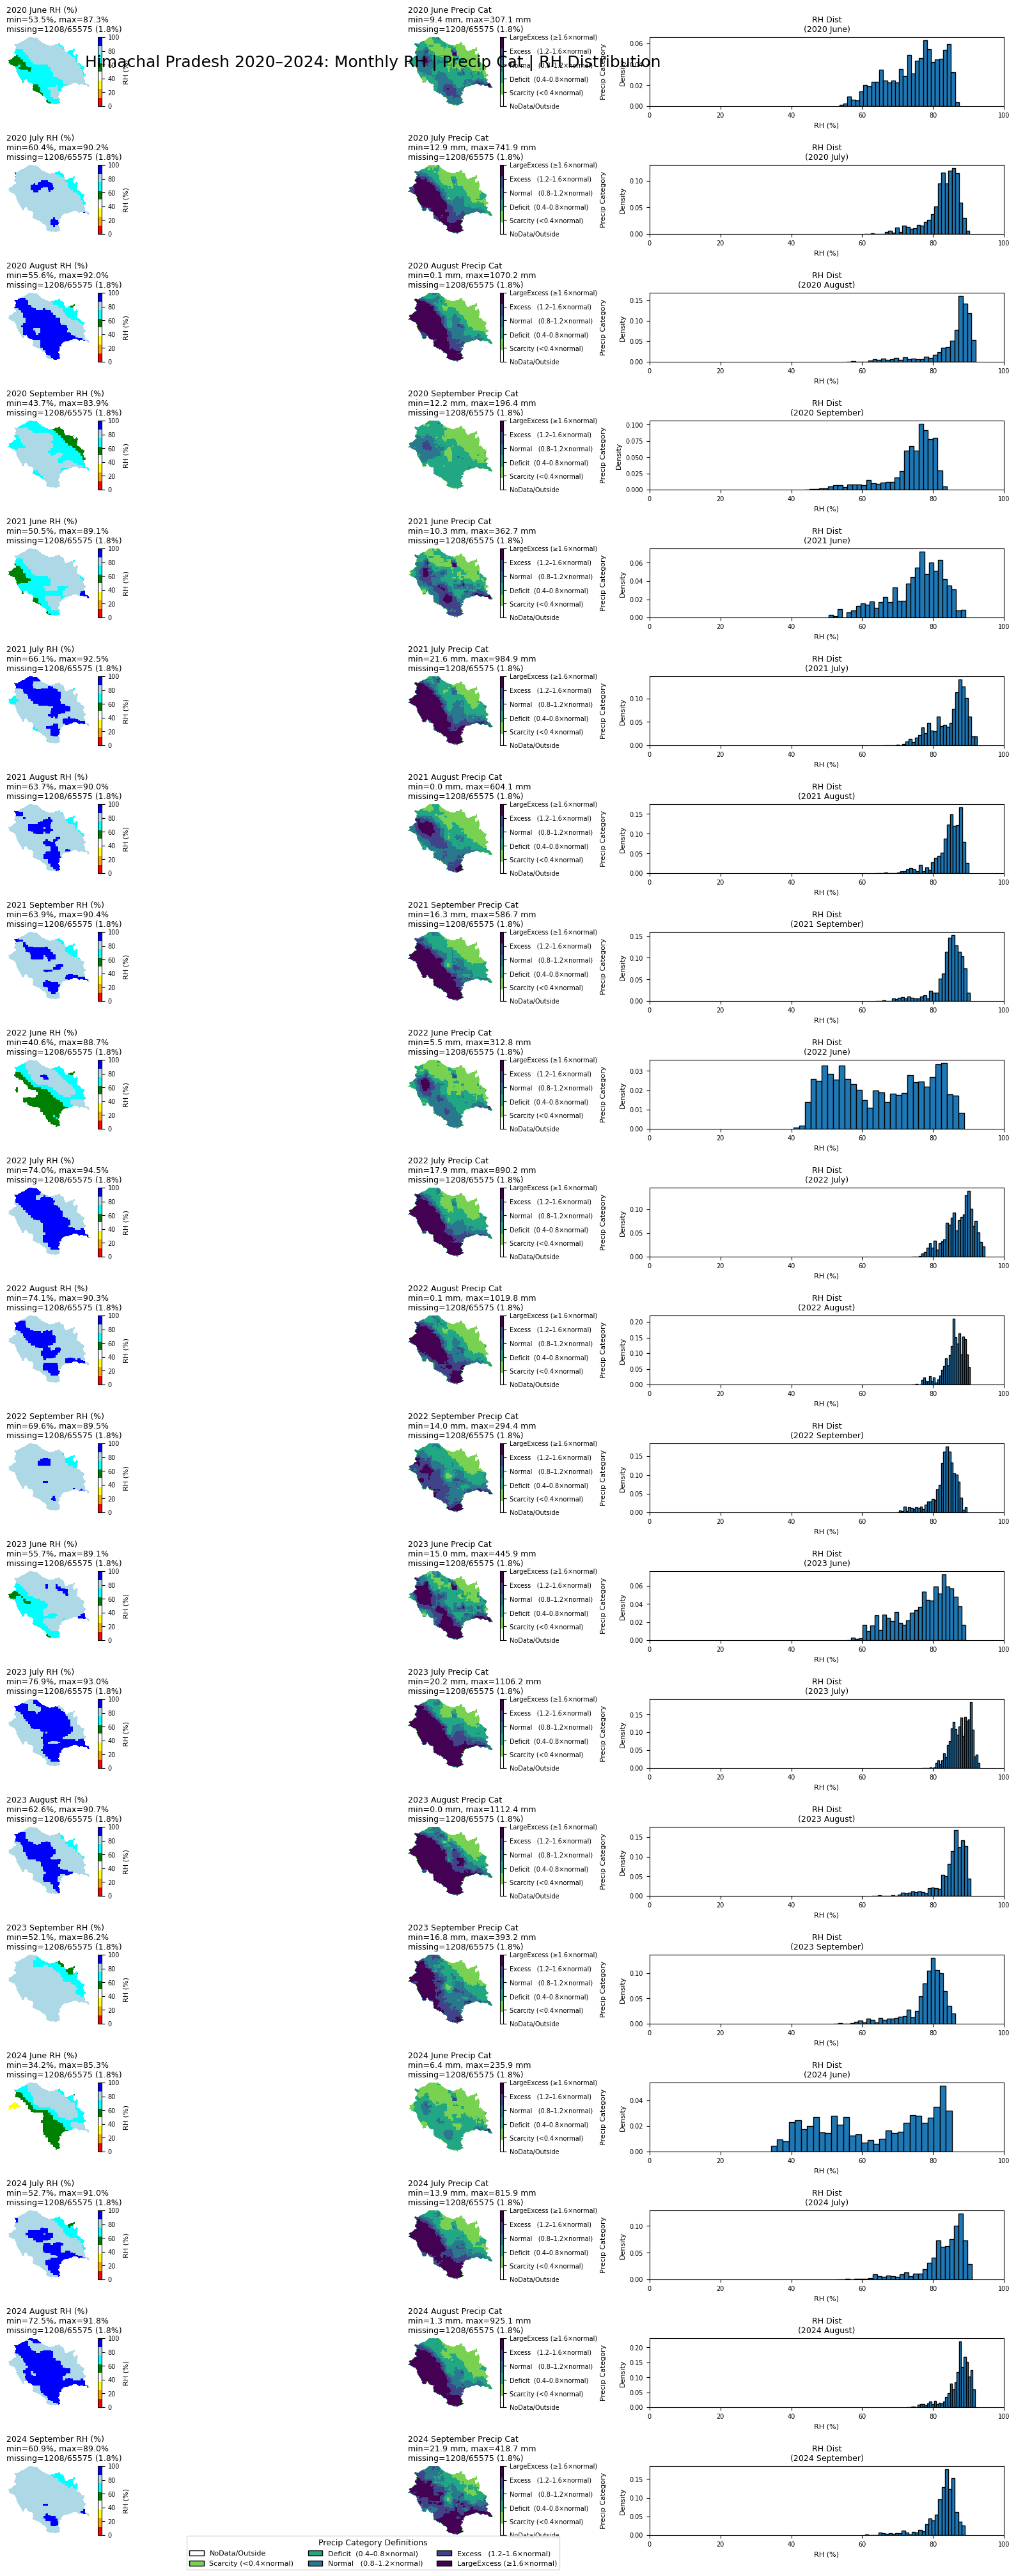

In [15]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Himachal Pradesh)
# -----------------------------------------------------------------------------
rh_tiff_path        = "Himachal_X_Relative_Humidity.tif"   # 20 bands (Jun–Sep, 2020–2024)
precip_raw_tiff     = "Himachal_Y_Precipitation_CHIRPS.tif" # 25 bands (2020–2024 × 5)
precip_cat_tiff     = "Himachal_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shapefile     = "SateMask/gadm41_IND_1.shp"                  # all Indian states

for p in (rh_tiff_path, precip_raw_tiff, precip_cat_tiff, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20-BAND RH TIFF
# -----------------------------------------------------------------------------
with rasterio.open(rh_tiff_path) as src:
    rh_bands     = src.read().astype(np.float32)  # (20, H, W)
    transform    = src.transform
    crs          = src.crs
    height, width = src.height, src.width
    bounds       = src.bounds

if rh_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {rh_tiff_path}, found {rh_bands.shape[0]}")

# 2a) Load Himachal Pradesh boundary & mask
gdf = gpd.read_file(india_shapefile)
gdf_hp = gdf[gdf["NAME_1"].str.lower() == "himachal pradesh"].copy()
if gdf_hp.empty:
    raise ValueError("No 'Himachal Pradesh' feature found in shapefile.")
if gdf_hp.crs != crs:
    gdf_hp = gdf_hp.to_crs(crs)

hp_geom = [gdf_hp.geometry.union_all()]
hp_mask = geometry_mask(
    hp_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)

total_inside = np.count_nonzero(hp_mask)
print(f"Total pixels inside Himachal Pradesh: {total_inside}")

# Mask RH outside HP → NaN
for i in range(rh_bands.shape[0]):
    band = rh_bands[i]
    band[~hp_mask] = np.nan
    rh_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK RAW PRECIPITATION (25 bands)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff}, found {pr_raw_full.shape[0]}")

for i in range(25):
    arr = pr_raw_full[i]
    arr[~hp_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK PRECIP CATEGORY (25 bands)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff}, found {pr_cat_full.shape[0]}")

for i in range(25):
    arr = pr_cat_full[i]
    arr[~hp_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIP BANDS (drop totals at idx 4,9,14,19,24)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs.extend([base + m for m in range(4)])

pr_raw_bands = pr_raw_full[monthly_idxs]   # (20, H, W)
pr_cat_bands = pr_cat_full[monthly_idxs]   # (20, H, W)

# -----------------------------------------------------------------------------
# 6) YEARS & MONTHS
# -----------------------------------------------------------------------------
years      = [2020, 2021, 2022, 2023, 2024]
months     = ["June", "July", "August", "September"]
n_months   = len(months)
n_total    = len(years) * n_months  # 20

# -----------------------------------------------------------------------------
# 7) COLORMAPS & LEGEND
# -----------------------------------------------------------------------------
# RH palette
rh_palette = ["red","orange","yellow","white","green","cyan","lightblue","blue"]
rh_cmap, rh_vmin, rh_vmax = ListedColormap(rh_palette), 0, 100

# Precip category palette
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE & PLOT
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Himachal Pradesh 2020–2024: Monthly RH | Precip Cat | RH Distribution", fontsize=18, y=0.98)
if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    y_idx, m_idx = divmod(i, n_months)
    year, mon = years[y_idx], months[m_idx]

    # RH stats + missing
    rh_layer  = rh_bands[i]
    valid_rh  = rh_layer[~np.isnan(rh_layer)]
    rh_min    = float(np.nanmin(valid_rh)) if valid_rh.size else np.nan
    rh_max    = float(np.nanmax(valid_rh)) if valid_rh.size else np.nan
    miss_rh   = np.count_nonzero(np.isnan(rh_layer[hp_mask]))
    pct_rh    = miss_rh / total_inside * 100
    print(f"{year} {mon} → Missing RH: {miss_rh}/{total_inside} ({pct_rh:.2f}%)")

    # precip stats + missing
    pr_layer  = pr_raw_bands[i]
    valid_pr  = pr_layer[~np.isnan(pr_layer)]
    pr_min    = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max    = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan
    miss_pr   = np.count_nonzero(np.isnan(pr_layer[hp_mask]))
    pct_pr    = miss_pr / total_inside * 100
    print(f"{year} {mon} → Raw Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # category map
    rc = pr_cat_bands[i]
    cp = np.zeros_like(rc, dtype=np.int8)
    ok = (rc != -1)
    cp[ok] = rc[ok] + 1

    # — Column 0: RH Map —
    ax0 = axes[i,0]
    im0 = ax0.imshow(rh_layer, cmap=rh_cmap, vmin=rh_vmin, vmax=rh_vmax,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], origin="upper")
    ax0.set_title(
        f"{year} {mon} RH (%)\nmin={rh_min:.1f}%, max={rh_max:.1f}%\n"
        f"missing={miss_rh}/{total_inside} ({pct_rh:.1f}%)",
        loc="left", fontsize=9
    )
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.045, pad=0.02)
    c0.set_label("RH (%)", fontsize=8); c0.ax.tick_params(labelsize=7)

    # — Column 1: Precip Cat Map —
    ax1 = axes[i,1]
    im1 = ax1.imshow(cp, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], origin="upper")
    ax1.set_title(
        f"{year} {mon} Precip Cat\nmin={pr_min:.1f} mm, max={pr_max:.1f} mm\n"
        f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)",
        loc="left", fontsize=9
    )
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=7); c1.set_label("Precip Category", fontsize=8)

    # — Column 2: RH Distribution —
    ax2 = axes[i,2]
    if valid_rh.size:
        ax2.hist(valid_rh.flatten(), bins=30, density=True, edgecolor="black")
        ax2.set_xlim(rh_vmin, rh_vmax)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"RH Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("RH (%)", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) LEGEND
# -----------------------------------------------------------------------------
fig.legend(handles=cluster_handles, loc="lower center", ncol=3,
           frameon=True, title="Precip Category Definitions",
           bbox_to_anchor=(0.5, -0.005), fontsize=8, title_fontsize=9)

plt.show()


In [ ]:
##Himachal_X_wind_speed

Total pixels inside Himachal Pradesh: 65575
2020 June → Wind missing: 1208/65575 (1.84%)
2020 June → Precip missing: 1208/65575 (1.84%)
2020 July → Wind missing: 1208/65575 (1.84%)
2020 July → Precip missing: 1208/65575 (1.84%)
2020 August → Wind missing: 1208/65575 (1.84%)
2020 August → Precip missing: 1208/65575 (1.84%)
2020 September → Wind missing: 1208/65575 (1.84%)
2020 September → Precip missing: 1208/65575 (1.84%)
2021 June → Wind missing: 1208/65575 (1.84%)
2021 June → Precip missing: 1208/65575 (1.84%)
2021 July → Wind missing: 1208/65575 (1.84%)
2021 July → Precip missing: 1208/65575 (1.84%)
2021 August → Wind missing: 1208/65575 (1.84%)
2021 August → Precip missing: 1208/65575 (1.84%)
2021 September → Wind missing: 1208/65575 (1.84%)
2021 September → Precip missing: 1208/65575 (1.84%)
2022 June → Wind missing: 1208/65575 (1.84%)
2022 June → Precip missing: 1208/65575 (1.84%)
2022 July → Wind missing: 1208/65575 (1.84%)
2022 July → Precip missing: 1208/65575 (1.84%)
2022 Aug

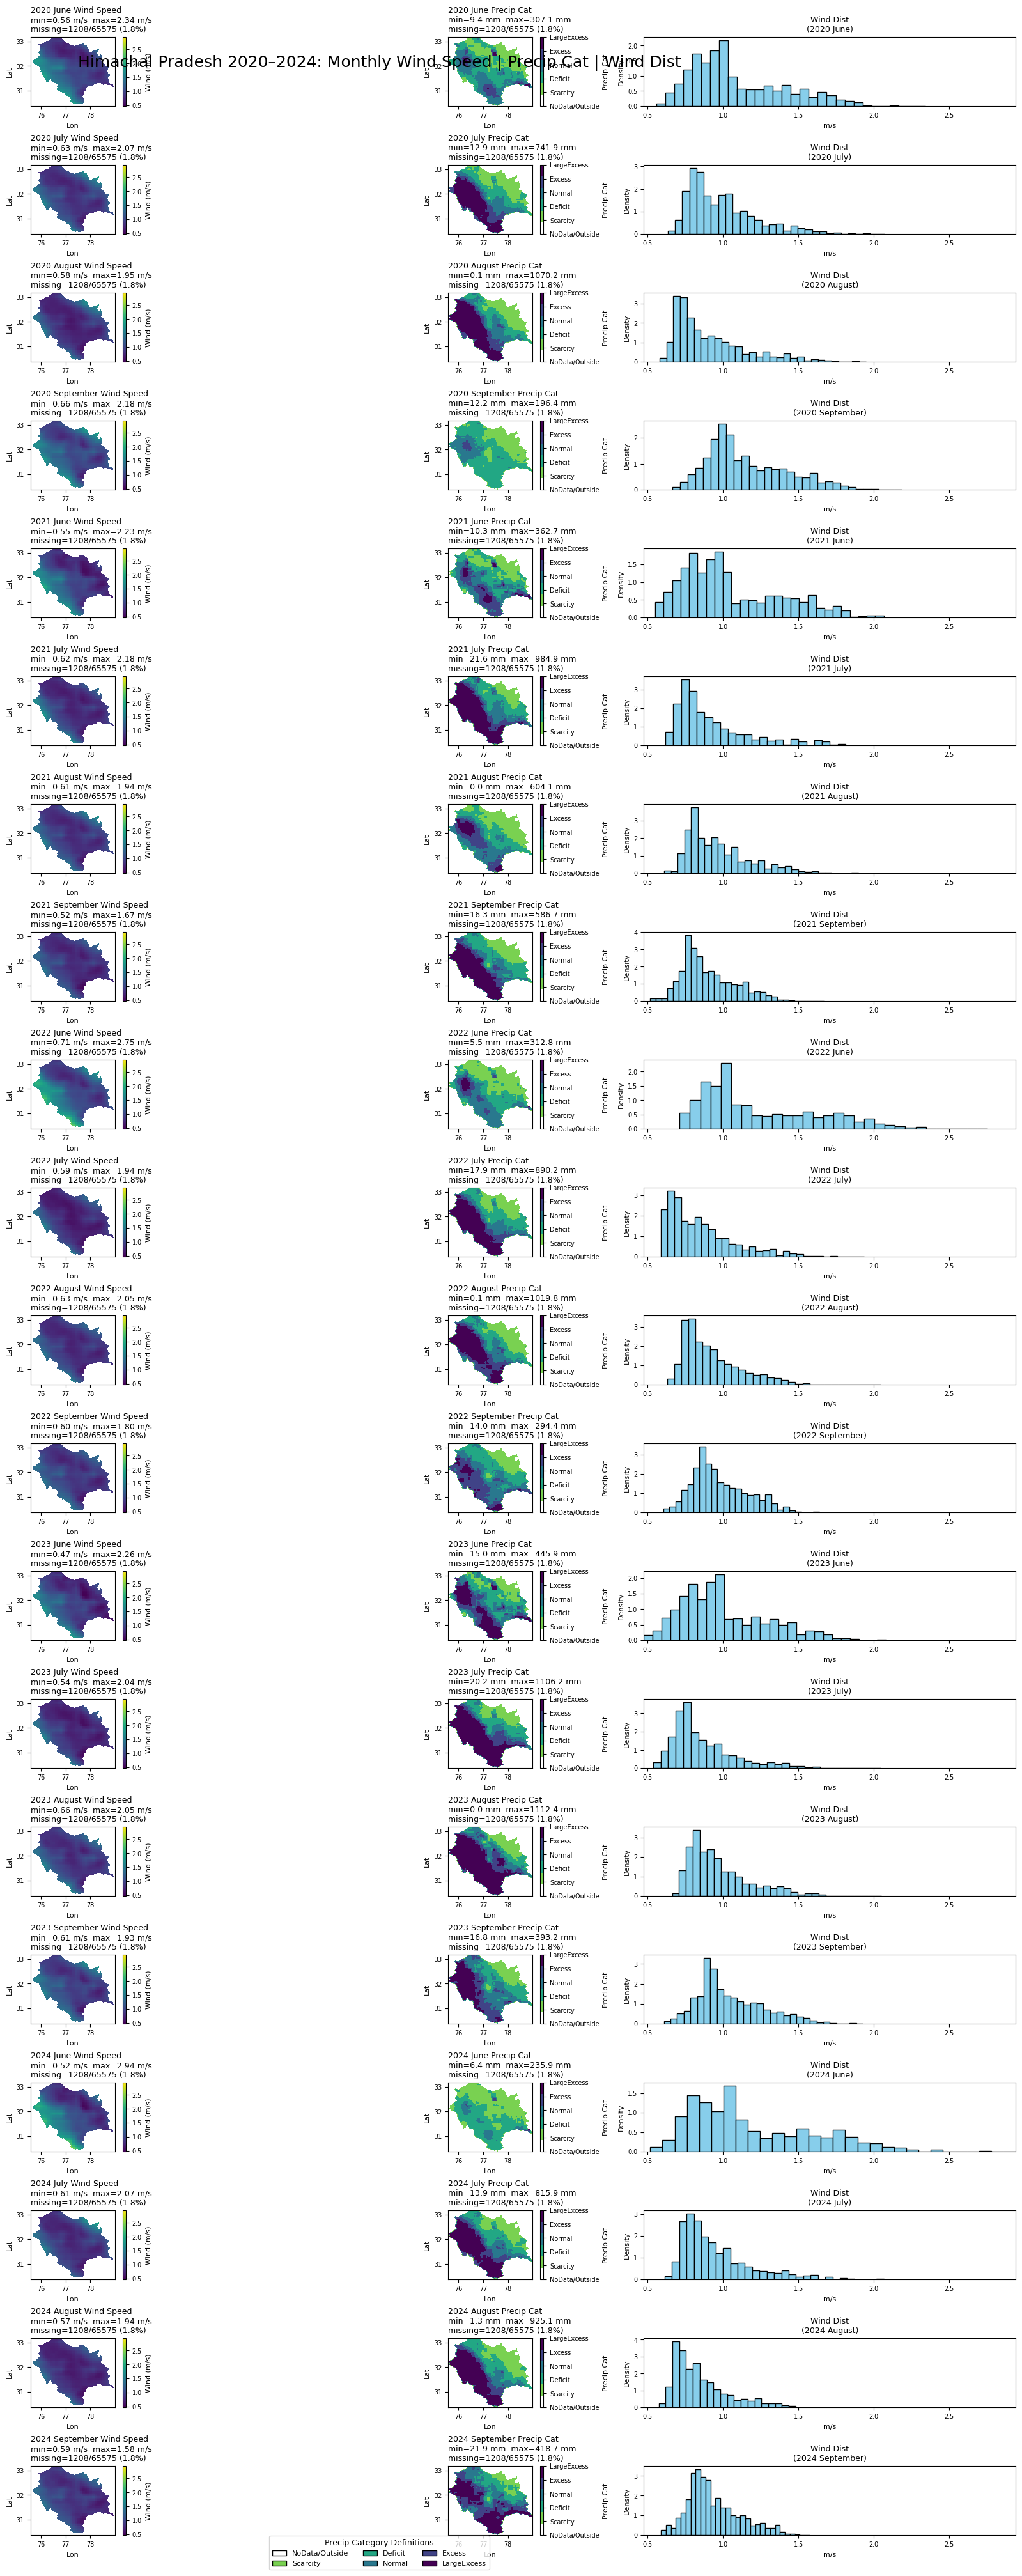

In [17]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Himachal Pradesh)
# -----------------------------------------------------------------------------
wind_tiff_path        = "Himachal_X_Wind_Speed.tif"               # 20 bands (Jun–Sep, 2020–2024)
precip_raw_tiff_path  = "Himachal_Y_Precipitation_CHIRPS.tif"     # 25 bands (2020–2024 × 5)
precip_cat_tiff_path  = "Himachal_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shapefile       = "SateMask/gadm41_IND_1.shp"                     # all Indian states

for p in (wind_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE WIND SPEED TIFF
# -----------------------------------------------------------------------------
with rasterio.open(wind_tiff_path) as src:
    wind_bands     = src.read().astype(np.float32)  # (20, H, W)
    transform      = src.transform
    crs            = src.crs
    height, width  = src.height, src.width
    bounds         = src.bounds

if wind_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {wind_tiff_path}, found {wind_bands.shape[0]}")

# 2a) Himachal mask
gdf = gpd.read_file(india_shapefile)
gdf_hp = gdf[gdf["NAME_1"].str.lower() == "himachal pradesh"].copy()
if gdf_hp.empty:
    raise ValueError("No 'Himachal Pradesh' feature found in shapefile.")
if gdf_hp.crs != crs:
    gdf_hp = gdf_hp.to_crs(crs)

hp_geom = [gdf_hp.geometry.union_all()]
hp_mask = geometry_mask(
    hp_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)
total_inside = np.count_nonzero(hp_mask)
print(f"Total pixels inside Himachal Pradesh: {total_inside}")

# Mask wind‐speed outside HP → NaN
for i in range(wind_bands.shape[0]):
    band = wind_bands[i]
    band[~hp_mask] = np.nan
    wind_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands, found {pr_raw_full.shape[0]}")

for i in range(25):
    arr = pr_raw_full[i]
    arr[~hp_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands, found {pr_cat_full.shape[0]}")

for i in range(25):
    arr = pr_cat_full[i]
    arr[~hp_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIPITATION BANDS (drop each year's “Total”)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]

precip_raw_bands = pr_raw_full[monthly_idxs]  # (20, H, W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years   = [2020, 2021, 2022, 2023, 2024]
months  = ["June", "July", "August", "September"]
n_months = len(months)
n_total  = len(years) * n_months  # 20

# -----------------------------------------------------------------------------
# 7) COLORMAPS & GLOBAL STATS
# -----------------------------------------------------------------------------
# Wind speed
ws_vals  = wind_bands.flatten()[~np.isnan(wind_bands.flatten())]
wind_vmin = float(np.nanmin(ws_vals)) if ws_vals.size else 0.0
wind_vmax = float(np.nanmax(ws_vals)) if ws_vals.size else 1.0
wind_cmap = plt.get_cmap("viridis")

# Precip category palette
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0:"NoData/Outside",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE & PLOT
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Himachal Pradesh 2020–2024: Monthly Wind Speed | Precip Cat | Wind Dist",
             fontsize=18, y=0.98)
if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    y_idx, m_idx = divmod(i, n_months)
    year, mon    = years[y_idx], months[m_idx]

    # Wind stats + missing
    ws_layer = wind_bands[i]
    valid_ws = ws_layer[~np.isnan(ws_layer)]
    ws_min   = float(np.nanmin(valid_ws)) if valid_ws.size else np.nan
    ws_max   = float(np.nanmax(valid_ws)) if valid_ws.size else np.nan
    miss_ws  = np.count_nonzero(np.isnan(ws_layer[hp_mask]))
    pct_ws   = miss_ws / total_inside * 100
    print(f"{year} {mon} → Wind missing: {miss_ws}/{total_inside} ({pct_ws:.2f}%)")

    # Precip stats + missing
    pr_layer = precip_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min   = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max   = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan
    miss_pr  = np.count_nonzero(np.isnan(pr_layer[hp_mask]))
    pct_pr   = miss_pr / total_inside * 100
    print(f"{year} {mon} → Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # Category map
    cat = precip_cat_bands[i]
    cp  = np.zeros_like(cat, dtype=np.int8)
    ok  = (cat != -1)
    cp[ok] = cat[ok] + 1

    # — Column 0: Wind Speed Map —
    ax0 = axes[i,0]
    im0 = ax0.imshow(ws_layer, cmap=wind_cmap, vmin=wind_vmin, vmax=wind_vmax,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    ax0.set_title(
        f"{year} {mon} Wind Speed\n"
        f"min={ws_min:.2f} m/s  max={ws_max:.2f} m/s\n"
        f"missing={miss_ws}/{total_inside} ({pct_ws:.1f}%)",
        loc="left", fontsize=9
    )
    ax0.set_xlabel("Lon", fontsize=8); ax0.set_ylabel("Lat", fontsize=8)
    ax0.tick_params(labelsize=7)
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.045, pad=0.02)
    c0.set_label("Wind (m/s)", fontsize=8); c0.ax.tick_params(labelsize=7)

    # — Column 1: Precip Cat Map —
    ax1 = axes[i,1]
    im1 = ax1.imshow(cp, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    ax1.set_title(
        f"{year} {mon} Precip Cat\n"
        f"min={pr_min:.1f} mm  max={pr_max:.1f} mm\n"
        f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)",
        loc="left", fontsize=9
    )
    ax1.set_xlabel("Lon", fontsize=8); ax1.set_ylabel("Lat", fontsize=8)
    ax1.tick_params(labelsize=7)
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=7); c1.set_label("Precip Cat", fontsize=8)

    # — Column 2: Wind Speed Distribution —
    ax2 = axes[i,2]
    if valid_ws.size:
        ax2.hist(valid_ws.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(wind_vmin, wind_vmax)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"Wind Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("m/s", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) BOTTOM LEGEND
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category Definitions",
    fontsize=8,
    title_fontsize=9,
    bbox_to_anchor=(0.5, -0.005)
)

plt.show()


In [ ]:
##Himachal_X_LULC

Total pixels inside Himachal Pradesh: 65575
2020 June → LULC missing: 0/65575 (0.00%)
2020 June → Precip missing: 1208/65575 (1.84%)
2020 July → LULC missing: 0/65575 (0.00%)
2020 July → Precip missing: 1208/65575 (1.84%)
2020 August → LULC missing: 0/65575 (0.00%)
2020 August → Precip missing: 1208/65575 (1.84%)
2020 September → LULC missing: 0/65575 (0.00%)
2020 September → Precip missing: 1208/65575 (1.84%)
2021 June → LULC missing: 0/65575 (0.00%)
2021 June → Precip missing: 1208/65575 (1.84%)
2021 July → LULC missing: 0/65575 (0.00%)
2021 July → Precip missing: 1208/65575 (1.84%)
2021 August → LULC missing: 0/65575 (0.00%)
2021 August → Precip missing: 1208/65575 (1.84%)
2021 September → LULC missing: 0/65575 (0.00%)
2021 September → Precip missing: 1208/65575 (1.84%)
2022 June → LULC missing: 0/65575 (0.00%)
2022 June → Precip missing: 1208/65575 (1.84%)
2022 July → LULC missing: 0/65575 (0.00%)
2022 July → Precip missing: 1208/65575 (1.84%)
2022 August → LULC missing: 0/65575 (0

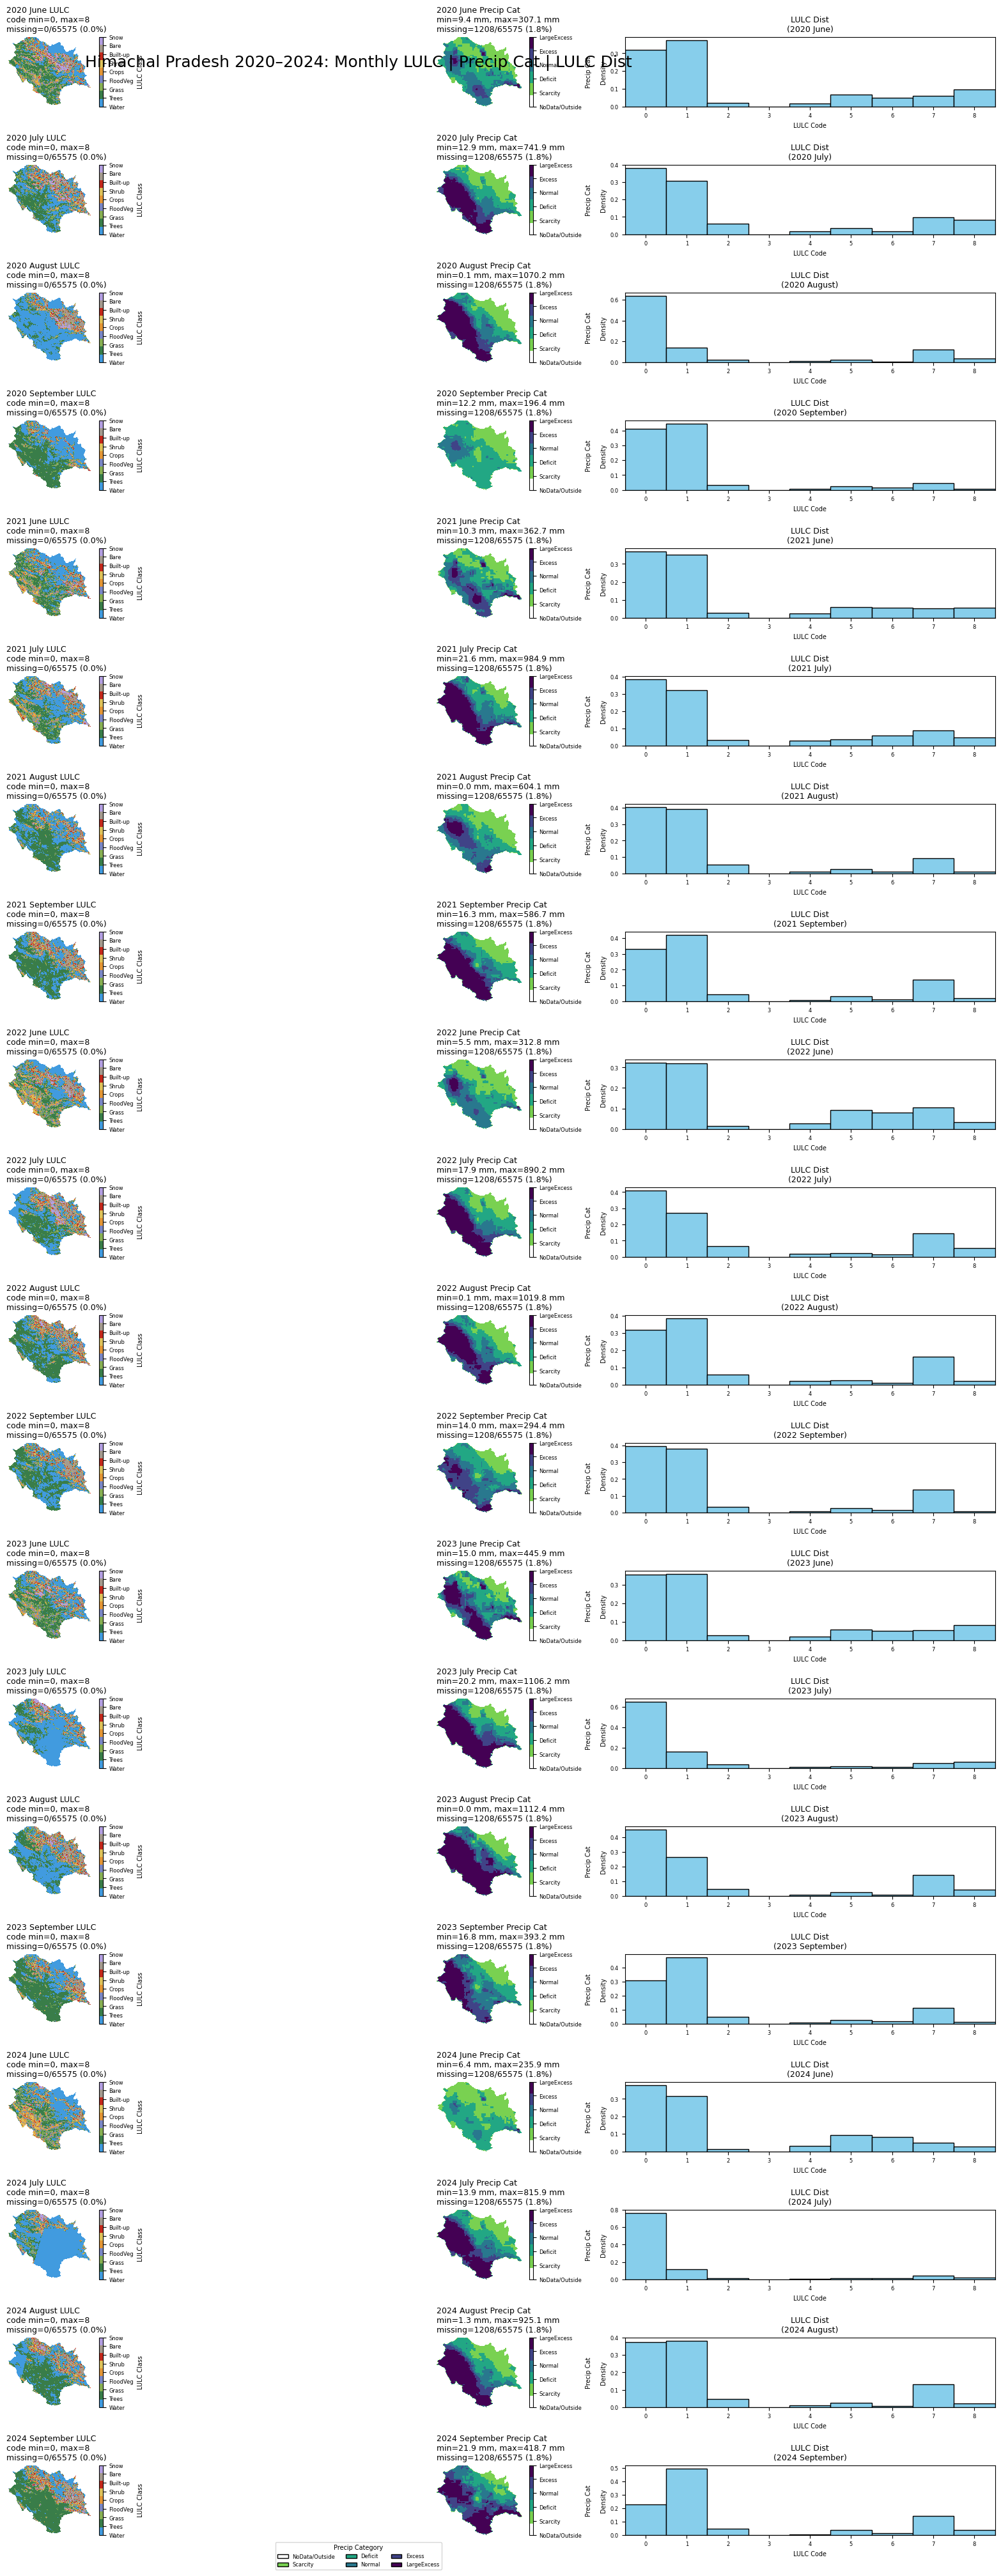

In [19]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Himachal Pradesh)
# -----------------------------------------------------------------------------
lulc_tiff_path        = "Himachal_X_LULC.tif"
precip_raw_tiff_path  = "Himachal_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path  = "Himachal_Y_Precipitation_GT_geotif.tif"
india_shapefile       = "SateMask/gadm41_IND_1.shp"

for p in (lulc_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20-BAND LULC TIFF
# -----------------------------------------------------------------------------
with rasterio.open(lulc_tiff_path) as src:
    lulc_bands    = src.read().astype(np.float32)  # (20, H, W)
    transform     = src.transform
    crs           = src.crs
    height, width = src.height, src.width
    bounds        = src.bounds

if lulc_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {lulc_tiff_path}, found {lulc_bands.shape[0]}")

# 2a) Load & mask Himachal Pradesh geometry
gdf = gpd.read_file(india_shapefile)
gdf_hp = gdf[gdf["NAME_1"].str.lower() == "himachal pradesh"].copy()
if gdf_hp.empty:
    raise ValueError("No 'Himachal Pradesh' feature found in shapefile.")
if gdf_hp.crs != crs:
    gdf_hp = gdf_hp.to_crs(crs)

hp_geom = [gdf_hp.geometry.union_all()]
hp_mask = geometry_mask(
    hp_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)
total_inside = np.count_nonzero(hp_mask)
print(f"Total pixels inside Himachal Pradesh: {total_inside}")

for i in range(lulc_bands.shape[0]):
    band = lulc_bands[i]
    band[~hp_mask] = np.nan
    lulc_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)
if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands, found {pr_raw_full.shape[0]}")
for i in range(25):
    arr = pr_raw_full[i]
    arr[~hp_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)
if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands, found {pr_cat_full.shape[0]}")
for i in range(25):
    arr = pr_cat_full[i]
    arr[~hp_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIP BANDS (drop totals at 4,9,14,19,24)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]
precip_raw_bands = pr_raw_full[monthly_idxs]  # (20, H, W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & GLOBAL STATS
# -----------------------------------------------------------------------------
dw_palette = ["#419bdf","#397d49","#88b053","#7a87c6",
              "#e49635","#dfc35a","#c4281b","#a59b8f","#b39fe1"]
lulc_cmap, lulc_vmin, lulc_vmax = ListedColormap(dw_palette), 0, 8

cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0:"NoData/Outside",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# overall precip raw min/max
all_pr = precip_raw_bands.flatten()
all_pr = all_pr[~np.isnan(all_pr)]
pr_vmin = float(np.nanmin(all_pr)) if all_pr.size else 0.0
pr_vmax = float(np.nanmax(all_pr)) if all_pr.size else 0.0

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE & PLOT
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Himachal Pradesh 2020–2024: Monthly LULC | Precip Cat | LULC Dist",
             fontsize=18, y=0.98)
if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    y_idx, m_idx = divmod(i, n_months)
    year, mon    = years[y_idx], month_names[m_idx]

    # LULC stats + missing
    lulc_layer = lulc_bands[i]
    valid_lc   = lulc_layer[~np.isnan(lulc_layer)]
    lc_min = int(np.nanmin(valid_lc)) if valid_lc.size else None
    lc_max = int(np.nanmax(valid_lc)) if valid_lc.size else None
    miss_lc = np.count_nonzero(np.isnan(lulc_layer[hp_mask]))
    pct_lc  = miss_lc / total_inside * 100
    print(f"{year} {mon} → LULC missing: {miss_lc}/{total_inside} ({pct_lc:.2f}%)")

    # precip stats + missing
    pr_layer = precip_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else None
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else None
    miss_pr = np.count_nonzero(np.isnan(pr_layer[hp_mask]))
    pct_pr  = miss_pr / total_inside * 100
    print(f"{year} {mon} → Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # category map
    raw_cat = precip_cat_bands[i]
    cat_plot = np.zeros_like(raw_cat, dtype=np.int8)
    ok = (raw_cat != -1)
    cat_plot[ok] = raw_cat[ok] + 1

    # — Column 0: LULC Map —
    ax0 = axes[i,0]
    im0 = ax0.imshow(lulc_layer, cmap=lulc_cmap, vmin=lulc_vmin, vmax=lulc_vmax,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    title0 = f"{year} {mon} LULC"
    if lc_min is not None:
        title0 += f"\ncode min={lc_min}, max={lc_max}"
    title0 += f"\nmissing={miss_lc}/{total_inside} ({pct_lc:.1f}%)"
    ax0.set_title(title0, loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_ticks(np.arange(0, 9))
    c0.ax.set_yticklabels(
        ["Water","Trees","Grass","FloodVeg","Crops","Shrub","Built-up","Bare","Snow"],
        fontsize=6
    )
    c0.ax.tick_params(labelsize=6)
    c0.set_label("LULC Class", fontsize=7)

    # — Column 1: Precip Cat Map —
    ax1 = axes[i,1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    title1 = f"{year} {mon} Precip Cat\nmin={pr_min:.1f} mm, max={pr_max:.1f} mm"
    title1 += f"\nmissing={miss_pr}/{total_inside} ({pct_pr:.1f}%)"
    ax1.set_title(title1, loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Cat", fontsize=7)

    # — Column 2: LULC Distribution —
    ax2 = axes[i,2]
    if valid_lc.size:
        bins = np.arange(-0.5, 9.5, 1.0)
        ax2.hist(valid_lc.flatten(), bins=bins, density=True, edgecolor="black", color="skyblue")
        ax2.set_xticks(np.arange(0, 9))
        ax2.set_xticklabels(np.arange(0, 9), fontsize=6)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_xlim(-0.5, 8.5)
    ax2.set_title(f"LULC Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("LULC Code", fontsize=7)
    ax2.set_ylabel("Density", fontsize=7)
    ax2.tick_params(labelsize=6)

# -----------------------------------------------------------------------------
# 10) LEGEND FOR PRECIP CATEGORIES
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category",
    fontsize=6,
    title_fontsize=7,
    bbox_to_anchor=(0.5,-0.005)
)

plt.show()


In [ ]:
##Himachal_X_Soil_Moisture

/tmp/ipykernel_105063/1360546011.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hp_geom = [gdf_hp.geometry.unary_union]
/tmp/ipykernel_105063/1360546011.py:77: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  [gdf_hp_pr.geometry.unary_union],


Total pixels inside Himachal Pradesh: 65575

2020 June → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2020 July → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2020 August → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2020 September → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2021 June → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2021 July → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2021 August → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2021 September → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2022 June → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2022 July → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2022 August → SM missing: 1208/65575 (1.84%)  | Precip missing: 1208/65575 (1.84%)
2022 September → SM missing: 1208/65575 (1.84%) 

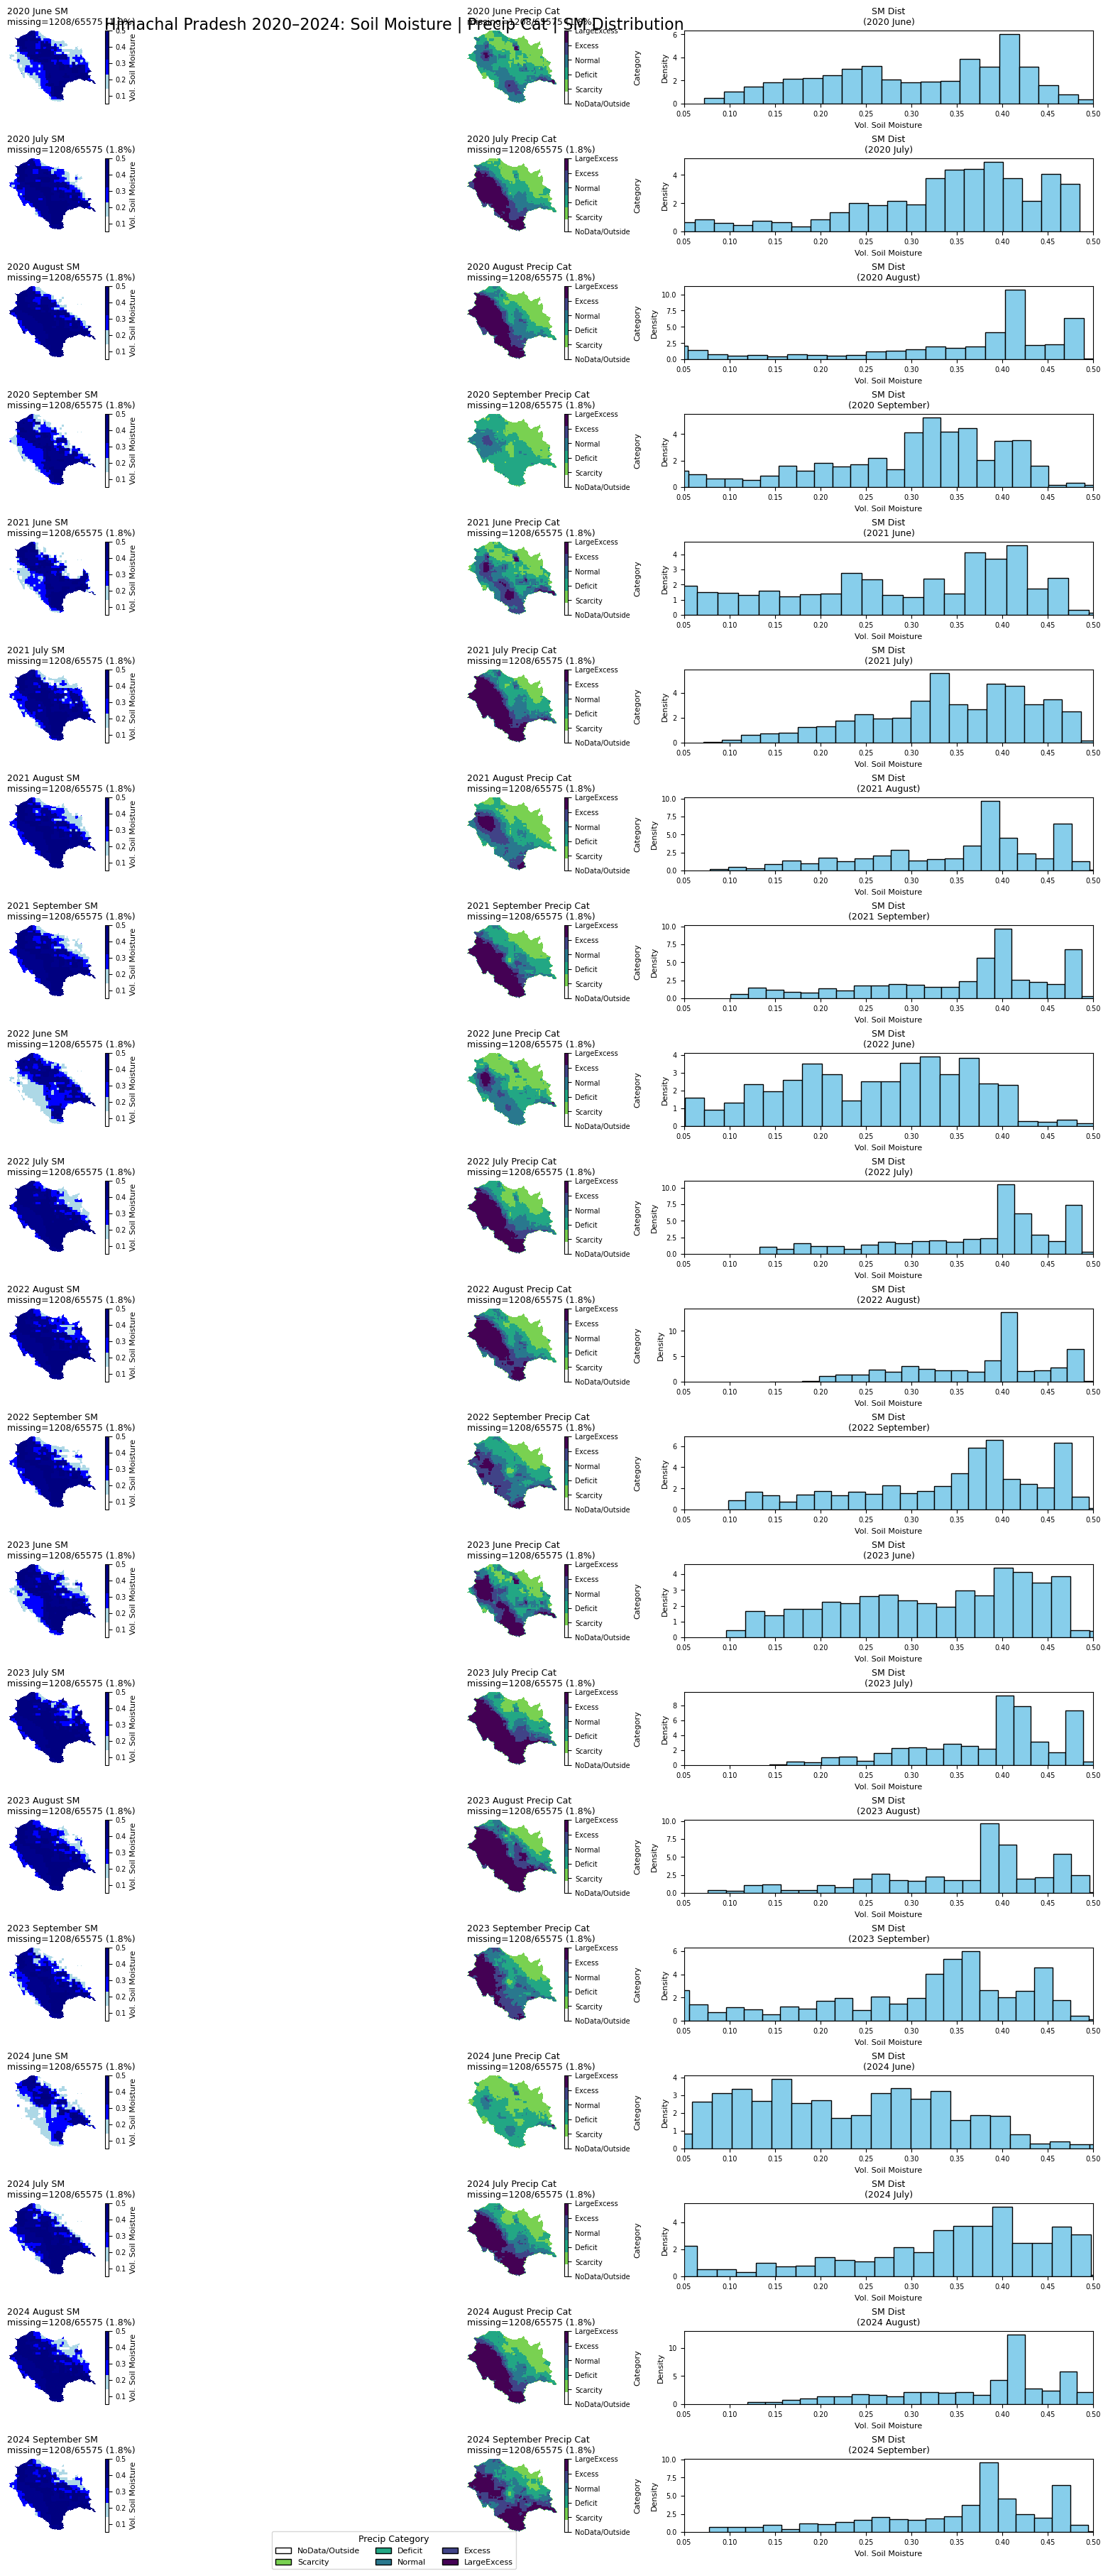

In [29]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Himachal Pradesh)
# -----------------------------------------------------------------------------
sm_tiff_path       = "Himachal_X_Soil_Moisture.tif"            # 20 bands (Jun–Sep 2020–2024)
precip_raw_tiff    = "Himachal_Y_Precipitation_CHIRPS.tif"     # 25 bands (2020–2024 × 5)
precip_cat_tiff    = "Himachal_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shapefile    = "SateMask/gadm41_IND_1.shp"               # India admin-1 boundaries

for p in (sm_tiff_path, precip_raw_tiff, precip_cat_tiff, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20-BAND SOIL MOISTURE TIFF
# -----------------------------------------------------------------------------
with rasterio.open(sm_tiff_path) as src_sm:
    sm_bands     = src_sm.read().astype(np.float32)  # (20, H, W)
    sm_transform = src_sm.transform
    sm_crs       = src_sm.crs
    H, W         = src_sm.height, src_sm.width
    bounds       = src_sm.bounds

if sm_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {sm_tiff_path}, found {sm_bands.shape[0]}")

# -----------------------------------------------------------------------------
# 3) LOAD & MASK HIMACHAL PRADESH FROM SHAPEFILE
# -----------------------------------------------------------------------------
gdf = gpd.read_file(india_shapefile)
# filter exactly “Himachal Pradesh”
gdf_hp = gdf[gdf["NAME_1"].str.lower() == "himachal pradesh"].copy()
if gdf_hp.empty:
    raise ValueError("No feature named 'Himachal Pradesh' found in shapefile.")
# reproject if needed
if gdf_hp.crs != sm_crs:
    gdf_hp = gdf_hp.to_crs(sm_crs)

hp_geom = [gdf_hp.geometry.unary_union]
hp_mask = geometry_mask(
    hp_geom,
    transform=sm_transform,
    invert=True,
    out_shape=(H, W)
)

total_inside = int(hp_mask.sum())
print(f"Total pixels inside Himachal Pradesh: {total_inside}\n")

# mask SM outside HP
for i in range(sm_bands.shape[0]):
    band = sm_bands[i]
    band[~hp_mask] = np.nan
    sm_bands[i]    = band

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25-BAND RAW PRECIPITATION TIFF
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff) as src_pr:
    pr_raw_full = src_pr.read().astype(np.float32)  # (25, H, W)
    pr_transform, pr_crs = src_pr.transform, src_pr.crs

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff}, found {pr_raw_full.shape[0]}")

# make sure mask in precip CRS
gdf_hp_pr = gdf_hp.to_crs(pr_crs)
hp_mask_pr = geometry_mask(
    [gdf_hp_pr.geometry.unary_union],
    transform=pr_transform,
    invert=True,
    out_shape=(H, W)
)

# mask raw precip
for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~hp_mask_pr] = np.nan
    pr_raw_full[i]   = arr

# -----------------------------------------------------------------------------
# 5) READ & MASK THE 25-BAND PRECIPITATION CATEGORY TIFF
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff) as src_pc:
    pr_cat_full = src_pc.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff}, found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    cat = pr_cat_full[i]
    cat[~hp_mask_pr] = -1
    pr_cat_full[i]   = cat

# -----------------------------------------------------------------------------
# 6) EXTRACT 20 MONTHLY BANDS (drop every 5th)
# -----------------------------------------------------------------------------
monthly_idx    = [year*5 + m for year in range(5) for m in range(4)]
sm_mon         = sm_bands              # already 20 bands
pr_raw_mon     = pr_raw_full[monthly_idx]
pr_cat_mon     = pr_cat_full[monthly_idx]

# -----------------------------------------------------------------------------
# 7) DEFINE YEARS, MONTHS & COLORMAPS
# -----------------------------------------------------------------------------
years      = [2020, 2021, 2022, 2023, 2024]
months     = ["June", "July", "August", "September"]
N          = len(years) * len(months)  # =20

# SM colormap: from dry→wet
sm_cmap   = ListedColormap(["white","lightblue","blue","darkblue","navy"])
sm_vmin, sm_vmax = 0.05, 0.5

# Precip category colormap
cat_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cat_cmap   = ListedColormap(cat_colors)
cat_labels = {
    0:"NoData/Outside",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cat_handles = [
    Patch(facecolor=cat_colors[i], edgecolor="black", label=cat_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) PRINT MISSING-DATA STATS
# -----------------------------------------------------------------------------
for i in range(N):
    y, m = divmod(i, 4)
    yr, mo = years[y], months[m]

    miss_sm = int(np.isnan(sm_mon[i][hp_mask]).sum())
    pct_sm  = miss_sm / total_inside * 100

    miss_pr = int(np.isnan(pr_raw_mon[i][hp_mask_pr]).sum())
    pct_pr  = miss_pr / total_inside * 100

    print(f"{yr} {mo} → SM missing: {miss_sm}/{total_inside} ({pct_sm:.2f}%)  |"
          f" Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")
print()

# -----------------------------------------------------------------------------
# 9) PLOT 20×3 PANELS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(N, 3, figsize=(20, N*1.8), constrained_layout=True)
fig.suptitle("Himachal Pradesh 2020–2024: Soil Moisture | Precip Cat | SM Distribution",
             fontsize=16, y=0.995)
if N == 1:
    axes = axes[np.newaxis, :]

for i in range(N):
    y, m    = divmod(i, 4)
    yr, mo  = years[y], months[m]

    # — Soil Moisture map —
    sm_layer = sm_mon[i]
    ax0      = axes[i,0]
    im0      = ax0.imshow(sm_layer, cmap=sm_cmap, vmin=sm_vmin, vmax=sm_vmax,
                          extent=[bounds.left,bounds.right,bounds.bottom,bounds.top],
                          origin="upper")
    miss_sm  = int(np.isnan(sm_layer[hp_mask]).sum())
    pct_sm   = miss_sm/total_inside*100
    ax0.set_title(f"{yr} {mo} SM\nmissing={miss_sm}/{total_inside}"
                  f" ({pct_sm:.1f}%)", loc="left", fontsize=9)
    ax0.axis("off")
    cb0      = fig.colorbar(im0, ax=ax0, fraction=0.045, pad=0.02)
    cb0.set_label("Vol. Soil Moisture", fontsize=8); cb0.ax.tick_params(labelsize=7)

    # — Precip Category map —
    raw_cat = pr_cat_mon[i]
    disp    = np.zeros_like(raw_cat, dtype=np.int8)
    ok      = (raw_cat != -1)
    disp[ok] = raw_cat[ok] + 1

    ax1     = axes[i,1]
    im1     = ax1.imshow(disp, cmap=cat_cmap, vmin=0, vmax=5,
                         extent=[bounds.left,bounds.right,bounds.bottom,bounds.top],
                         origin="upper")
    miss_pr = int(np.isnan(pr_raw_mon[i][hp_mask_pr]).sum())
    pct_pr  = miss_pr/total_inside*100
    ax1.set_title(f"{yr} {mo} Precip Cat\nmissing={miss_pr}/{total_inside}"
                  f" ({pct_pr:.1f}%)", loc="left", fontsize=9)
    ax1.axis("off")
    cb1     = fig.colorbar(im1, ax=ax1, fraction=0.045, pad=0.02)
    cb1.set_ticks([0,1,2,3,4,5])
    cb1.set_ticklabels([cat_labels[j] for j in range(6)], fontsize=6)
    cb1.ax.tick_params(labelsize=7); cb1.set_label("Category", fontsize=8)

    # — SM distribution histogram —
    vals = sm_layer[~np.isnan(sm_layer)]
    ax2  = axes[i,2]
    if vals.size:
        ax2.hist(vals.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(sm_vmin, sm_vmax)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", color="gray", fontsize=8)
    ax2.set_title(f"SM Dist\n({yr} {mo})", fontsize=9)
    ax2.set_xlabel("Vol. Soil Moisture", fontsize=8)
    ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) BOTTOM LEGEND
# -----------------------------------------------------------------------------
fig.legend(handles=cat_handles, loc="lower center", ncol=3,
           frameon=True, title="Precip Category", fontsize=8, title_fontsize=9,
           bbox_to_anchor=(0.5, -0.005))

plt.show()


In [ ]:
##Himachal_X_elevation